# Lab 03 : GatedGCNs for Molecule Property Regression - demo


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = '01_GatedGCNs_Molecule_Regression.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd
    !apt-get install python-rdkit librdkit1 rdkit-data -qq

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import time
import datetime
import numpy as np
import pickle
import argparse
import sys
import collections
import os

# remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# molecule toolkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


In [2]:
notebook_mode = True

# select GPU for notebook
if notebook_mode == True:
    gpu_id = 0  # select GPU id: 0,1,2,3
    server_id = 181
    
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    gpu_id = -1
    server_id = -1
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    

cuda not available


In [3]:
# load dataset
class bucket(object):
    """
    INPUT: list of smiles corresponding to molecules of the SAME size (N atoms),
           list of corresponding rdkit molecules 
           atom and bond dictionaries
           
    ATTRIBUTE: self.atom: Tensor of size bs x N     (atom composition of the molecule)
               self.rep:  Tensor of size bs x N     (repeat feature) 
               self.bond: Tensor of size bs x N x N (adjacency matrix)
               self.smile: list containing all the smiles 
    """
    
    def __init__(self, smile_list, rdkitmol_list, atom_dict, bond_dict ):
        
        self.N= rdkitmol_list[0].GetNumAtoms()
        self.bs = len(rdkitmol_list)
        
        self.atom  =  torch.zeros( self.bs , self.N).long()
        self.rep   =  torch.zeros( self.bs , self.N).long()
        self.bond  =  torch.zeros( self.bs , self.N, self.N).long()
        self.smile =  smile_list
        
        for idx, mol in enumerate(rdkitmol_list):
            
            n = mol.GetNumAtoms()
            if n != self.N:
                print('ERROR: mol does not have right size')
                
            at,r,bd = rdkitMol2pytorchTensor(mol, atom_dict, bond_dict)
            self.atom[idx]=at
            self.rep[idx]=r
            self.bond[idx]=bd
            
    def __len__(self):
        return self.bs
    
    
class bucket_helper(object):
    """
    provide a mapping from bucket idx to size of molecule contained in the given bucket
    """ 
    def __init__(self, data):
        self.bucket2size=[]
        self.size2bucket={}
        self.num_molecules=[]

        for idx,bucket in enumerate(data):
            sz=bucket.N
            self.bucket2size.append(sz)
            self.size2bucket[sz]=idx
            
            
            
data_folder= 'datasets/dataQM9/'

pickle_in = open(data_folder + "train.pickle","rb")
data_train = pickle.load(pickle_in)
pickle_in = open(data_folder + "test.pickle","rb")
data_test = pickle.load(pickle_in)

import dictionaries as dic

pickle_in = open(data_folder + "atom_dict.pickle","rb")
atom_dict = pickle.load(pickle_in)
pickle_in = open(data_folder + "bond_dict.pickle","rb")
bond_dict = pickle.load(pickle_in)

pickle_in = open(data_folder + "info_train.pickle","rb")
info_train = pickle.load(pickle_in)
pickle_in = open(data_folder + "info_test.pickle","rb")
info_test = pickle.load(pickle_in)


In [4]:
print('Print histogram of molecule sizes')

print('\n############# Train Molecules ##############\n')

data = data_train
for bucket in data:
    print('number of molecule of size {}: \t {}'.format(bucket.N, len(bucket)))
    
print('\n############# Test Molecules ##############\n')
      
data = data_test
for bucket in data:
    print('number of molecule of size {}: \t {}'.format(bucket.N, len(bucket)))

Print histogram of molecule sizes

############# Train Molecules ##############

number of molecule of size 1: 	 2
number of molecule of size 2: 	 5
number of molecule of size 3: 	 8
number of molecule of size 4: 	 25
number of molecule of size 5: 	 102
number of molecule of size 6: 	 535
number of molecule of size 7: 	 2763
number of molecule of size 8: 	 15552
number of molecule of size 9: 	 94887

############# Test Molecules ##############

number of molecule of size 4: 	 1
number of molecule of size 5: 	 13
number of molecule of size 6: 	 36
number of molecule of size 7: 	 222
number of molecule of size 8: 	 1387
number of molecule of size 9: 	 8341


In [5]:
# select one pucket of same molecules size, here molecules with 7 atoms

def keep_bucket_of_size(dataset,sz_to_keep):
    new_dataset=[]
    for bucket in dataset:
        if bucket.N in sz_to_keep:
            new_dataset.append(bucket)
    return new_dataset

sz_to_keep = [7] # [8,9] 
data_test  = keep_bucket_of_size(data_test,sz_to_keep)
data_train = keep_bucket_of_size(data_train,sz_to_keep)


CC12NC1C1OC12
tensor([1, 1, 2, 1, 1, 0, 1])
['O', 'C', 'N', 'F']
tensor([[0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 1, 1, 0]])
['NONE', 'SINGLE', 'DOUBLE', 'AROMATIC', 'TRIPLE']


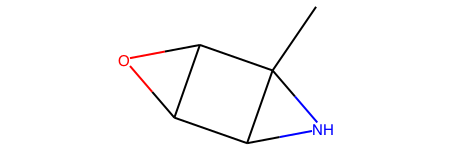

In [6]:
# visualize dataset and molecule with RDKit

idx_bucket = 0
idx_mol = 45

smile = data_train[idx_bucket].smile[idx_mol]
print(smile)

print(data_train[idx_bucket].atom[idx_mol])
print(atom_dict.idx2word)

print(data_train[idx_bucket].bond[idx_mol])
print(bond_dict.idx2word)

mol = Chem.MolFromSmiles(smile)
mol


In [7]:
def compute_bucket_stats(data):

    size_of_mol_in_bucket=[]
    num_mol_in_bucket=[]

    for idx,bucket in enumerate(data):
        size_of_mol_in_bucket.append(bucket.N)
        num_mol_in_bucket.append(bucket.bs)

    size_of_mol_in_bucket = torch.LongTensor(size_of_mol_in_bucket)
    num_mol_in_bucket = torch.LongTensor(num_mol_in_bucket)

    return size_of_mol_in_bucket, num_mol_in_bucket


possible_sizes, num_mol_per_bucket = compute_bucket_stats(data_train)
print(possible_sizes)
print(num_mol_per_bucket)


tensor([7])
tensor([2763])


In [8]:
# sample randomly a mini-bacth of N molecules

class sampler_class(object):
    """
    INPUT: 
        possible_sizes:   LongTensor containing the possible sizes
        num_mol_per_bucket: LongTensor containing the number of molecule for each given bucket
        bs: batch size
    
    """
    
    def __init__(self, bs, possible_sizes, num_mol_per_bucket):  
        
        self.possible_sizes = possible_sizes
        self.num_mol_per_bucket = num_mol_per_bucket
        self.num_buckets = len(possible_sizes)
        self.bs=bs
        self.not_empty = True

        # compute the number of batches held in each bucket (note: this is a float)
        self.num_remaining_batch_per_bucket = torch.floor( num_mol_per_bucket.float() / bs )
        
        # initialize the idx to zero for each bucket
        self.mol_idx_in_bucket=torch.zeros( self.num_buckets ).long()
        
        
    def get_bucket_idx_and_mol_idx(self):
          
        prob = self.num_remaining_batch_per_bucket / self.num_remaining_batch_per_bucket.sum()
        
        # choose one bucket at random, 
        # get num of atoms corresponding to this bucket
        # and get the idx of the first molecule for the batch to be extracted
        bucket_idx = np.random.choice( self.num_buckets  , p=prob.numpy() )
        mol_idx = self.mol_idx_in_bucket[bucket_idx].item()
        
        # update the trackers
        self.num_remaining_batch_per_bucket[bucket_idx] -= 1
        self.mol_idx_in_bucket[bucket_idx] += self.bs
   
        if self.num_remaining_batch_per_bucket.sum().long() == 0:
            self.not_empty=False
            
        return bucket_idx , mol_idx
    
    
    
    
batch_size = 5
sampler = sampler_class(batch_size, possible_sizes, num_mol_per_bucket)

buck_idx, mol_idx = sampler.get_bucket_idx_and_mol_idx()
#print(buck_idx)
#print(mol_idx)


In [9]:
# network parameters
net_parameters = {}
net_parameters['nb_atoms'] = len(atom_dict.idx2word)
net_parameters['nb_bonds'] = len(bond_dict.idx2word)
net_parameters['max_atom_count'] = data_train[-1].N

net_parameters['hidden_dim'] = 50 # debug
net_parameters['L'] = 2           # debug

if notebook_mode == True:
    print(net_parameters)


{'nb_atoms': 4, 'nb_bonds': 5, 'max_atom_count': 7, 'hidden_dim': 50, 'L': 2}


In [10]:

class node_convnet_feat(nn.Module):
    """
    convnet features for nodes
    x_i = U*x_i +  sum_j gate_ij * (V*x_j)
    size of input x : B x V x H
    size of output edge_gate : B x V x V x H
    """
    def __init__(self, hidden_dim):        
        super(node_convnet_feat, self).__init__()
         
        self.U  = nn.Linear(hidden_dim, hidden_dim, True)
        self.V  = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, edge_gate):
        
        Ux = self.U(x) # B x V x H
        Vx = self.V(x) # B x V x H
        Vx = Vx.unsqueeze(1) # extend Vx from "B x V x H" to "B x 1 x V x H"
        gateVx = edge_gate* Vx # B x V x V x H
        x_new = Ux + torch.sum( gateVx , dim=2) # B x V x H
        
        return x_new

    
class edge_convnet_feat(nn.Module):
    """
    convnet features for edges
    e_ij = U*e_ij + V*x_i + W*x_j
    size of input x : B x V x H
    size of output e : # B x V x V x H
    """
    def __init__(self, hidden_dim):        
        super(edge_convnet_feat, self).__init__()
         
        self.U  = nn.Linear(hidden_dim, hidden_dim, True)
        self.V  = nn.Linear(hidden_dim, hidden_dim, True)
        self.W  = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, e):
        
        Ue = self.U(e)
        Vx = self.V(x)
        Wx = self.W(x)
        Vx = Vx.unsqueeze(2) # extend Vx from "B x V x H" to "B x V x 1 x H"
        Wx = Wx.unsqueeze(1) # extend Wx from "B x V x H" to "B x 1 x V x H"
        e_new = Ue + Vx + Wx
        
        return e_new

    
class bn_node(nn.Module):
    """
    batch normalization for nodes
    size of input x : B x V x H
    size of output x_bn : B x V x H
    """
    def __init__(self, hidden_dim):        
        super(bn_node, self).__init__()
        
        self.bn = nn.BatchNorm1d(hidden_dim) 

    def forward(self, x):
        
        x_trans = x.transpose(1,2).contiguous() # input must be of shape: B x H x V
        x_trans_bn = self.bn(x_trans)
        x_bn = x_trans_bn.transpose(1,2).contiguous() 
        
        return x_bn

    
class bn_edge(nn.Module):
    """
    batch normalization for edges
    size of input e : B x V x V x H
    size of output e_bn : B x V x V x H
    """
    def __init__(self, hidden_dim):        
        super(bn_edge, self).__init__()
        
        self.bn = nn.BatchNorm2d(hidden_dim) 

    def forward(self, e):
        
        e_trans = e.transpose(1,3).contiguous() # input must be of shape: B x H x V x V
        e_trans_bn = self.bn(e_trans)
        e_bn = e_trans_bn.transpose(1,3).contiguous() 
        
        return e_bn

    
class edges_to_vector(nn.Module):
    """
    vector representation of all edges 
    z = sum_ij gate_ij * (A*e_ij)
    where gate_ij = sigmoid(U*e_ij + V*x_i + W*x_j)
    size of input x : B x V x H
    size of output e : # B x V x V x H
    """
    def __init__(self, hidden_dim):        
        super(edges_to_vector, self).__init__()
        
        self.gate = edge_convnet_feat(hidden_dim)
        self.A = nn.Linear(hidden_dim, hidden_dim, True)

    def forward(self, x, e):
        
        edge_gate = self.gate(x,e)
        edge_gate = F.sigmoid(edge_gate)
        Ae = self.A(e)
        gateAe = edge_gate * Ae
        # sum over all edges ij
        z = torch.sum(gateAe, dim=1)
        z = torch.sum(z, dim=1)
        
        return z

    
class mlp(nn.Module):
    """
    3-layer perceptron class
    size of input x : B x H
    size of output y : B x 1
    """
    def __init__(self, hidden_dim, output_dim):        
        super(mlp, self).__init__()
        
        self.U = nn.Linear(hidden_dim, hidden_dim, True)
        self.V = nn.Linear(hidden_dim, output_dim, True)

    def forward(self, x):
        
        Ux = self.U(x) # B x H
        y = F.relu(Ux) # B x H
        y = self.V(y) # B x H
        
        return y


class basic_convnet_layer(nn.Module):
    """
    basic convnet class
    size of input x : B x V x H
    size of input e : B x V x V x H
    size of output x_new : B x V x H
    size of output e_new : B x V x V x H
    """
    def __init__(self, hidden_dim):        
        super(basic_convnet_layer, self).__init__()
        
        self.node_convnet_feat = node_convnet_feat(hidden_dim)
        self.edge_convnet_feat = edge_convnet_feat(hidden_dim)
        self.bn_node = bn_node(hidden_dim)      
        self.bn_edge = bn_edge(hidden_dim)     
        
    def forward(self, x, e):
        
        e_in = e
        x_in = x
        e_tmp = self.edge_convnet_feat(x_in, e_in) # B x V x V x H
        edge_gate = F.sigmoid(e_tmp)
        x_tmp = self.node_convnet_feat(x_in, edge_gate)
        e_tmp = self.bn_edge(e_tmp)
        x_tmp = self.bn_node(x_tmp)
        e = F.relu(e_tmp)
        x = F.relu(x_tmp)
        x_new = x_in + x 
        e_new = e_in + e 
 
        return x_new, e_new


class molecule_encoder(nn.Module):
    """
    molecule encoder class
    size of input train_x_node : B x V
    size of input train_x_edge : B x V x V
    size of output z : B x H
    """
    def __init__(self, nb_atoms, nb_bonds, hidden_dim, L):        
        super(molecule_encoder, self).__init__()
        
        # atoms embedding
        self.atoms_embedding = nn.Embedding(nb_atoms, hidden_dim)

        # bonds embedding
        self.bonds_embedding = nn.Embedding(nb_bonds, hidden_dim) 

        # list of convnet layers
        convnet_layers = [] 
        for layer in range(L):
            convnet_layers.append(basic_convnet_layer(hidden_dim))
        self.convnet_layers = nn.ModuleList(convnet_layers)

        # edges to vector 
        self.edges_to_vector = edges_to_vector(hidden_dim)
        
        # class variables
        self.L = L
        
    def forward(self, train_x_node, train_x_edge):
        
        x = self.atoms_embedding(train_x_node) # B x V x H
        e = self.bonds_embedding(train_x_edge) # B x V x V x H
        for layer in range(self.L):
            x,e = self.convnet_layers[layer](x,e) # B x V x H,  B x V x V x H
        z = self.edges_to_vector(x,e) # B x H
       
        return z

    
class MoleculeNet_regression(nn.Module):
    """
    network for molecule regression
    """
    def __init__(self, net_parameters):        
        super(MoleculeNet_regression, self).__init__()
        
        # parameters
        nb_atoms = net_parameters['nb_atoms']
        nb_bonds = net_parameters['nb_bonds']
        hidden_dim = net_parameters['hidden_dim']
        L = net_parameters['L']
        #print(nb_atoms,nb_bonds,hidden_dim,output_dim,L)
        
        # molecule encoder: from molecule to vector representation (computed with graph convnet)
        self.molecule_encoder = molecule_encoder(nb_atoms, nb_bonds, hidden_dim, L)
        
        # regression part
        output_dim = 1
        self.mlp = mlp(hidden_dim, output_dim)
        
    def forward(self, train_x_node, train_x_edge):
        
        z = self.molecule_encoder(train_x_node, train_x_edge) # B x H
        regression_value = self.mlp(z).squeeze() # B
    
        return regression_value
    
        
    def loss(self, y, y_target):
        
        #loss = nn.MSELoss()(y,y_target)
        loss = nn.L1Loss()(y,y_target)
        
        return loss
       
        
    def chemical_accuracy(self, y, y_target):
        
        chemical_accuracy_LUMO = 0.043
        MAE = F.l1_loss(y, y_target)
        MAE /= chemical_accuracy_LUMO

        return MAE 


    def update(self, lr):
                
        update = torch.optim.Adam( self.parameters(), lr=lr )
        
        return update
    
    
    def update_learning_rate(self, optimizer, lr):
   
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    
    
    
# simple forward test   
if notebook_mode == True:

    # instantiate the network
    net = MoleculeNet_regression(net_parameters)
    if torch.cuda.is_available():
        net.cuda()
    print(net)


    # number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('nb_param=',nb_param)


    # forward
    batch_size = 5
    sampler = sampler_class(batch_size, possible_sizes, num_mol_per_bucket)
    buck_idx, mol_idx = sampler.get_bucket_idx_and_mol_idx()
    train_x_node = Variable( torch.LongTensor(data_train[buck_idx].atom[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
    train_x_node_count = Variable( torch.LongTensor(data_train[buck_idx].rep[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
    train_x_edge = Variable( torch.LongTensor(data_train[buck_idx].bond[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
    train_y = Variable( torch.FloatTensor(data_train[buck_idx].lumo[mol_idx:mol_idx+batch_size]).type(dtypeFloat) , requires_grad=False)

    y = net.forward(train_x_node, train_x_edge) # B x 1
    print(y.size())
    print(y)

    

MoleculeNet_regression(
  (molecule_encoder): molecule_encoder(
    (atoms_embedding): Embedding(4, 50)
    (bonds_embedding): Embedding(5, 50)
    (convnet_layers): ModuleList(
      (0): basic_convnet_layer(
        (node_convnet_feat): node_convnet_feat(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_convnet_feat): edge_convnet_feat(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
          (W): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): bn_node(
          (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (bn_edge): bn_edge(
          (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): basic_convnet_layer(
        (node_convnet_feat): node_co

In [11]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.001
opt_parameters['max_epochs'] = 1 ########### debug
opt_parameters['decay_rate'] = 1.25
opt_parameters['batch_size'] = 50


# simple backward test  
if notebook_mode == True:

    print(opt_parameters)

    learning_rate = opt_parameters['learning_rate']
    max_epochs = opt_parameters['max_epochs']
    decay_rate = opt_parameters['decay_rate']


    # compute loss 
    loss = net.loss(y,train_y)
    print(loss)

    
    # define optimizer
    lr = learning_rate
    optimizer = net.update(lr) 


    # backward
    optimizer.zero_grad()
    loss.backward()


    # update
    optimizer.step()


{'learning_rate': 0.001, 'max_epochs': 1, 'decay_rate': 1.25, 'batch_size': 50}
tensor(1.5384, grad_fn=<L1LossBackward>)


In [12]:

def train_one_epoch(net,optimizer,opt_parameters):
    """
    train one epoch
    """

    net.train()
    
    batch_size = opt_parameters['batch_size']
    
    possible_sizes, num_mol_per_bucket = compute_bucket_stats(data_train)
    sampler = sampler_class(batch_size, possible_sizes, num_mol_per_bucket)
    
    shuffling_map = []
    for bucket_size in list(num_mol_per_bucket):
        shuffling_map.append(np.random.permutation(bucket_size.item()))
    
    running_loss = 0.0
    running_acc = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    while sampler.not_empty:
        
        # extract batch
        buck_idx, mol_idx = sampler.get_bucket_idx_and_mol_idx()
        x_node = Variable( torch.LongTensor(data_train[buck_idx].atom[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
        x_edge = Variable( torch.LongTensor(data_train[buck_idx].bond[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
        y_target = Variable( torch.FloatTensor(data_train[buck_idx].lumo[mol_idx:mol_idx+batch_size]).type(dtypeFloat) , requires_grad=False)

        # forward, backward, optimize
        optimizer.zero_grad()
        y = net.forward(x_node, x_edge) # B 
        loss = net.loss(y,y_target)
        loss.backward()
        optimizer.step()
        
        # compute loss, accuracy
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()    
        running_acc += batch_size* net.chemical_accuracy(y,y_target).item()   
        running_nb_batch += 1 # for intermediate result

        # print intermediate result
        if 2==1:
            if running_nb_batch%100==0:
                 print('{}: loss={}'.format(running_nb_data,running_loss/running_nb_data))
               
            
    # loss and acc values for one epoch
    loss = running_loss/ running_nb_data
    acc = running_acc/ running_nb_data
    
    return loss, acc


    
# simple train loop   
if notebook_mode==True and gpu_id==-1:
    train_loss, train_acc = train_one_epoch(net, optimizer, opt_parameters)
    print(train_loss, train_acc)


0.7496257554401051 17.433156551014292


In [13]:
 
def evaluate_test_set(net, opt_parameters):
    """
    evaluate test set
    """

    net.eval()
    
    batch_size = opt_parameters['batch_size'] 
    
    possible_sizes, num_mol_per_bucket = compute_bucket_stats(data_test)
    sampler = sampler_class(batch_size, possible_sizes, num_mol_per_bucket)
    
    running_loss = 0.0
    running_acc = 0.0
    running_nb_data = 0
    
    while sampler.not_empty:
        
        # extract batch
        buck_idx, mol_idx = sampler.get_bucket_idx_and_mol_idx()
        x_node = Variable( torch.LongTensor(data_test[buck_idx].atom[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
        x_edge = Variable( torch.LongTensor(data_test[buck_idx].bond[mol_idx:mol_idx+batch_size]).type(dtypeLong) , requires_grad=False)
        y_target = Variable( torch.FloatTensor(data_test[buck_idx].lumo[mol_idx:mol_idx+batch_size]).type(dtypeFloat) , requires_grad=False)
    
        # forward, backward, optimize
        y = net.forward(x_node, x_edge) # B 
        loss = net.loss(y,y_target)
        
        # compute loss, accuracy
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()    
        running_acc += batch_size* net.chemical_accuracy(y,y_target).item()  

        
    # loss and acc values for one epoch
    loss = running_loss/ running_nb_data
    acc = running_acc/ running_nb_data
    
    return loss, acc


    
# simple test loop   
if notebook_mode==True and gpu_id==-1:
    test_loss, test_acc = evaluate_test_set(net, opt_parameters)
    print(test_loss, test_acc)


0.6023355722427368 14.007803678512573


In [14]:

###############
# parameters values in notebook mode
###############
if notebook_mode == True:

    # network parameters
    net_parameters = {}
    net_parameters['nb_atoms'] = len(atom_dict.idx2word)
    net_parameters['nb_bonds'] = len(bond_dict.idx2word)
    net_parameters['max_atom_count'] = data_train[-1].N
    net_parameters['hidden_dim'] = 50 # 200
    net_parameters['L'] = 3 # 12
    
    # optimization parameters
    opt_parameters = {}
    opt_parameters['learning_rate'] = 0.001
    opt_parameters['max_epochs'] = 20  
    opt_parameters['decay_rate'] = 1.2
    opt_parameters['batch_size'] = 50
    
    # save results
    args = []
    args.append(['max_nb_atoms',net_parameters['max_atom_count']])
    args.append(['max_epochs',opt_parameters['max_epochs']])
    args.append(['batch_size',opt_parameters['batch_size']])
    args.append(['decay_rate',opt_parameters['decay_rate']])
    args.append(['learning_rate',opt_parameters['learning_rate']])
    args.append(['hidden_dim',net_parameters['hidden_dim']])
    args.append(['L',net_parameters['L']])
    args.append(['gpu_id',gpu_id])
    args.append(['server_id',server_id])
    

In [15]:

def main(args):
    """
    main function
    """
    
    # instantiate the network
    net = MoleculeNet_regression(net_parameters)
    if torch.cuda.is_available():
        net.cuda()
    print(net)
    
    # number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('net_parameters:',net_parameters)
    print('opt_parameters:',opt_parameters)
    print('nb net parameters:',nb_param)
    
    # train parameters
    train_loss_old = 1e6
    lr = opt_parameters['learning_rate']
    decay_rate = opt_parameters['decay_rate']
    optimizer = net.update(lr) 
    max_epochs = opt_parameters['max_epochs']
    
    # define optimizer
    optimizer = net.update(lr) 

    # loop over epochs
    start = time.time()
    for epoch in range(max_epochs):
        
        start_epoch = time.time()
        
        # train, test
        train_loss, train_acc = train_one_epoch(net, optimizer, opt_parameters)
        test_loss, test_acc = evaluate_test_set(net, opt_parameters)
        
        # update learning rate 
        if train_loss > 0.99* train_loss_old:
            lr /= decay_rate
        optimizer = net.update_learning_rate(optimizer, lr)
        train_loss_old = train_loss
        
        # print intermediate results
        print_one_epoch_result = ( 'gpu:{ID}  epoch:{EP} epoch time:{epoch_time:.0f}s total time:{fromstart:.1f}h '
                   'lr:{LR:.2e} '
                   'loss:{train_loss:.3f}/{test_loss:.3f} '
                   'MAE:{train_acc:.3f}/{test_acc:.3f} '.format(
                    ID=gpu_id,
                    EP=epoch,
                    fromstart=(time.time()-start)/3600,          
                    epoch_time=time.time()-start_epoch,
                    LR= lr,  
                    train_loss=train_loss, test_loss=test_loss,
                    train_acc=train_acc, test_acc=test_acc ) )
        print(print_one_epoch_result)
        
        
          
            
# run main function           
main(args)       


MoleculeNet_regression(
  (molecule_encoder): molecule_encoder(
    (atoms_embedding): Embedding(4, 50)
    (bonds_embedding): Embedding(5, 50)
    (convnet_layers): ModuleList(
      (0): basic_convnet_layer(
        (node_convnet_feat): node_convnet_feat(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_convnet_feat): edge_convnet_feat(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
          (W): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): bn_node(
          (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (bn_edge): bn_edge(
          (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): basic_convnet_layer(
        (node_convnet_feat): node_co